# Data Engineering Capstone Project

## Package Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StringType
from pyspark.sql.types import *

## Create Spark Session

In [3]:
spark = SparkSession.builder.\
    config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

## Step 1: Scope the Project and Gather Data


To create the analytics database, the following steps will be carried out:

* Use Spark to load the data into dataframes.
* Exploratory data analysis of I94 immigration dataset to identify missing values and strategies for data cleaning.
* Exploratory data analysis of demographics dataset to identify missing values and strategies for data cleaning.
* Exploratory data analysis of global land temperatures by city dataset to identify missing values and strategies for data cleaning.
* Perform data cleaning functions on all the datasets.
* Create dimension tables and fact tables.


### Load I94 data

In [4]:
# read in the data
fname = '../../data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat'
immigration_df =spark.read.format('com.github.saurfang.sas.spark').load(fname)

In [5]:
immigration_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,687.0,2016.0,9.0,213.0,213.0,HOU,20698.0,1.0,TX,20725.0,...,None,M,1989.0,11022016,M,None,QK,9.527939e+10,8111,B1
1,799.0,2016.0,9.0,369.0,369.0,WAS,20698.0,1.0,VA,20725.0,...,None,M,1945.0,11032016,M,None,KL,9.531093e+10,651,B2
2,1001.0,2016.0,9.0,582.0,582.0,LVG,20698.0,1.0,NV,20702.0,...,None,M,1991.0,10312016,M,None,4O,9.507648e+10,970,B2
3,1044.0,2016.0,9.0,691.0,582.0,MIA,20698.0,1.0,FL,20702.0,...,None,M,1966.0,11032016,M,None,AM,9.532965e+10,428,B1
4,1183.0,2016.0,9.0,266.0,266.0,CHI,20698.0,1.0,WI,20714.0,...,None,M,1982.0,D/S,F,None,UA,9.465594e+10,5959,F1


In [6]:
immigration_df.select("visapost").dropDuplicates().show(5)

+--------+
|visapost|
+--------+
|     CRS|
|     BGM|
|     KGL|
|     AKD|
|     TRK|
+--------+
only showing top 5 rows



### Load World Temperature Data 

In [7]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = spark.read.csv(file_name, header=True, inferSchema=True)

In [8]:
temperature_df.show(n=5)

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 5 rows



In [9]:
temperature_df.count()

8599212

### Load US Cities Demographic data

In [10]:
demographics_df = spark.read.csv("us-cities-demographics.csv", inferSchema=True, header=True, sep=';')

In [11]:
demographics_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [12]:
demographics_df.count()

2891

## Step 2: Explore and Assess the Data

In [13]:
def visualize_missing_values_pandas(df):
    """
    Visualize missing value in a panda dataframe
    
    param df: pandas dataframe
    
    """
    nulls_df = pd.DataFrame(data= df.isnull().sum(), columns=['values'])
    nulls_df = nulls_df.reset_index()
    nulls_df.columns = ['cols', 'values']

    # calculate percent of missing values
    nulls_df['% missing values'] = 100*nulls_df['values']/df.shape[0]

    plt.rcdefaults()
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x="cols", y="% missing values", data=nulls_df)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

In [14]:
def visualize_missing_values_spark(df):
    """
    Visualize missing values in a spark dataframe
    
    param df: spark dataframe
    """
    # create a dataframe with missing values count per column
    nan_count_df = df.select([count(when(isnan(c) | df[c].isNull(), c)).alias(c) for c in df.columns]).toPandas()
    
    # convert dataframe from wide format to long format
    nan_count_df = pd.melt(nan_count_df, var_name='cols', value_name='values')
    
    # count total records in df
    total = df.count()
    
    # now lets add % missing values column
    nan_count_df['% missing values'] = 100*nan_count_df['values']/total
    
    plt.rcdefaults()
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x="cols", y="% missing values", data=nan_count_df)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

### I94 Data Assessment

In [15]:
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

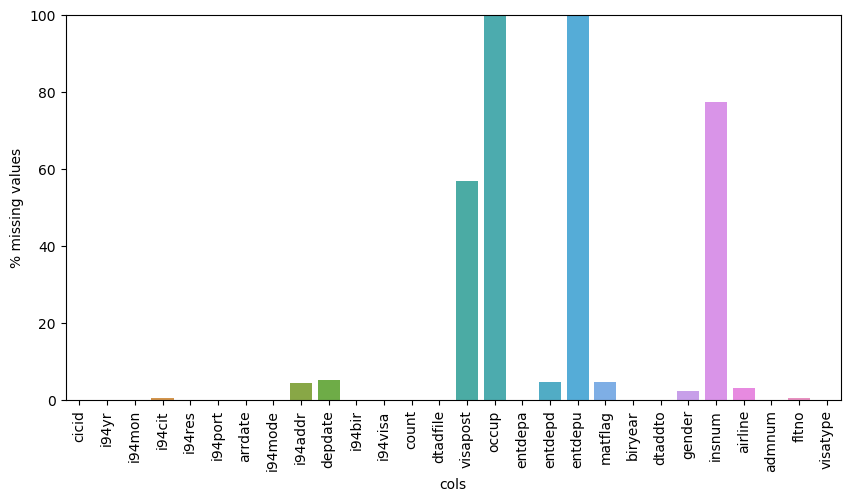

In [16]:
visualize_missing_values_spark(immigration_df)

In [17]:
# As we can see there are 3 columns with missing values over 90%, we need to drop these columns
col = ['occup', 'entdepu','insnum']
new_immigration_df = immigration_df.drop(*col)

In [18]:
new_immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [19]:
new_immigration_df.count()

3733786

In [20]:
new_immigration_df = new_immigration_df.dropDuplicates(['cicid'])
new_immigration_df = new_immigration_df.dropna(how='all', subset=['cicid'])

In [21]:
new_immigration_df.count()

3733786

As we can see, there is no missing value and duplicate value in the new dataframe. 

### World Temperature Data Assessment

In [22]:
temperature_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [23]:
new_temp = temperature_df.withColumn("dt",temperature_df.dt.cast(StringType()))


In [24]:
new_temp.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



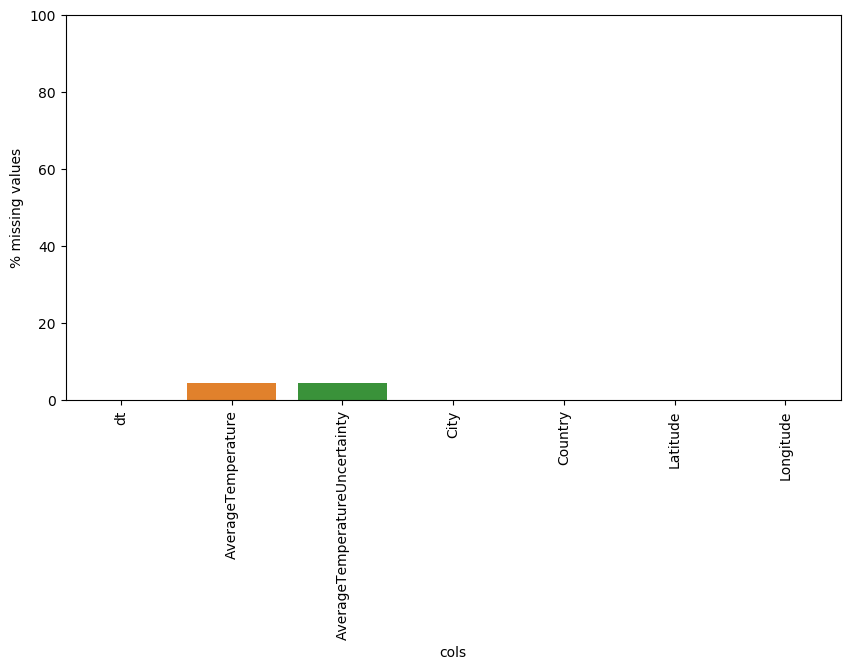

In [25]:
visualize_missing_values_spark(new_temp)


In [26]:
# We're going to drop duplicates and missing rows here 
df_temp_clean = new_temp.dropna(subset=['AverageTemperature','AverageTemperatureUncertainty'])
df_temp_clean = df_temp_clean.dropDuplicates(subset=['dt', 'City', 'Country'])

In [27]:
df_temp_clean.count()

8190783

### US Demographic Data Assessment

In [28]:
demographics_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



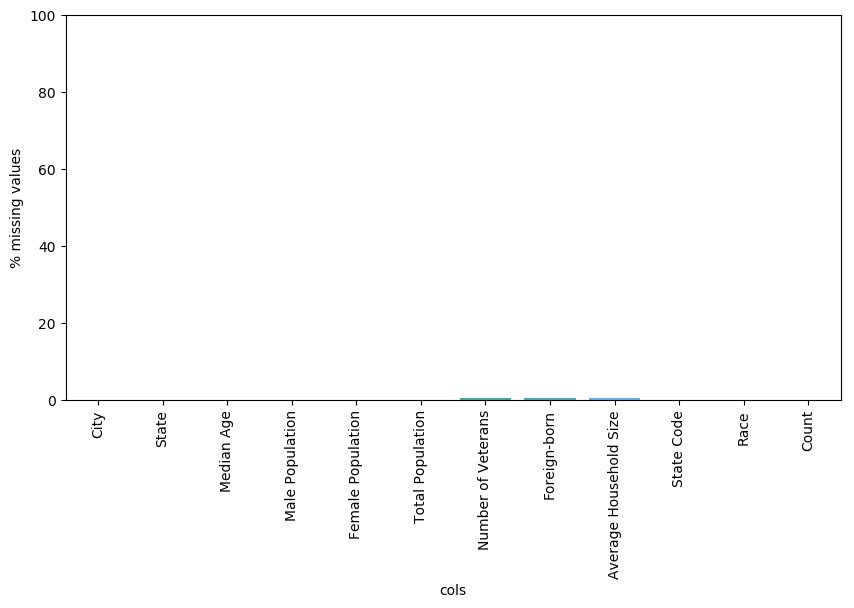

In [29]:
visualize_missing_values_spark(demographics_df)

In [30]:
clean_demo_df = demographics_df.dropna(subset=['Number of Veterans','Foreign-born','Average Household Size'])
clean_demo_df = clean_demo_df.drop_duplicates(subset=['City', 'State', 'State Code', 'Race'])

In [31]:
clean_demo_df.count()

2875

## Step 3: Define the Data Model

![schema](image.png)

> Above we have the Star Schema. We have immigration table in the center, which includes all the information about immigration. Then we have four dimension table. 

> Demographics Table includes all the US demographic information. 

> Calendar Table includes all the arrival time information. 

> Visa Type Table includes all the visa type. 

> Country Table includes country information. 

### Step 4: Run ETL to Model the Data

In [43]:
output_data = "tables/"

#### create visa type table

In [44]:
def create_visa_type_table(df, output_data):
    """This function creates a visa type dimension from the immigration data.
    
    :param df: spark dataframe of immigration events
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # create visatype df from visatype column
    visatype_df = df.select(['visatype']).distinct()
    
    # add an id column
    visatype_df = visatype_df.withColumn('visa_type_key', monotonically_increasing_id())
    
    # write dimension to parquet file
    visatype_df.write.parquet(output_data + "visatype", mode="overwrite")
    
    return visatype_df

def get_visa_type_dimension(output_data):
    return spark.read.parquet(output_data + "visatype")

In [46]:
# test create visa_type dimension function
visatype_df = create_visa_type_table(new_immigration_df, output_data)
visatype_df.show(n=5)

+--------+-------------+
|visatype|visa_type_key|
+--------+-------------+
|      F2| 103079215104|
|     GMB| 352187318272|
|      B2| 369367187456|
|      F1| 498216206336|
|     CPL| 601295421440|
+--------+-------------+
only showing top 5 rows



#### create calendar table

In [51]:
def create_calendar_table(df, output_data):
    """This function creates an calendar table based on arrival date
    
    :param df: spark dataframe of immigration events
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # create a udf to convert arrival date in SAS format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # create initial calendar df from arrdate column
    calendar_df = df.select(['arrdate']).withColumn("arrdate", get_datetime(df.arrdate)).distinct()
    
    # expand df by adding other calendar columns
    calendar_df = calendar_df.withColumn('arrival_day', dayofmonth('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_week', weekofyear('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_month', month('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_year', year('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_weekday', dayofweek('arrdate'))

    # create an id field in calendar df
    calendar_df = calendar_df.withColumn('id', monotonically_increasing_id())
    
    # write the calendar dimension to parquet file
    partition_columns = ['arrival_year', 'arrival_month', 'arrival_week']
    calendar_df.write.parquet(output_data + "calendar", partitionBy=partition_columns, mode="overwrite")
    
    return calendar_df

In [60]:
calendar_df = create_calendar_table(new_immigration_df, output_data)
calendar_df.show(5)

+----------+-----------+------------+-------------+------------+---------------+------------+
|   arrdate|arrival_day|arrival_week|arrival_month|arrival_year|arrival_weekday|          id|
+----------+-----------+------------+-------------+------------+---------------+------------+
|2016-09-11|         11|          36|            9|        2016|              1|  8589934592|
|2016-09-21|         21|          38|            9|        2016|              4| 60129542144|
|2016-09-27|         27|          39|            9|        2016|              3| 60129542145|
|2016-09-14|         14|          37|            9|        2016|              4| 77309411328|
|2016-09-13|         13|          37|            9|        2016|              3|111669149696|
+----------+-----------+------------+-------------+------------+---------------+------------+
only showing top 5 rows



#### create country table

In [69]:
def aggregate_temperature_data(df):
    """Aggregate clean temperature data at country level
    
    :param df: spark dataframe of clean global temperaturs data
    :return: spark dataframe consisting of countries average temperatures
    """
    new_df = df.select(['Country', 'AverageTemperature']).groupby('Country').avg()
    
    new_df = new_df.withColumnRenamed('avg(AverageTemperature)', 'average_temperature')
    
    return new_df


def create_country_table(df, temp_df, output_data):
    """This function creates a country dimension from the immigration and global land temperatures data.
    
    :param df: spark dataframe of immigration events
    :temp_df: spark dataframe of global land temperatures data.
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # get the aggregated temperature data
    agg_temp = aggregate_temperature_data(temp_df).toPandas()
    # load the i94res to country mapping data
    mapping_codes = pd.read_csv('i94res.csv')
    
    @udf('string')
    def get_country_average_temperature(name):
        print("Processing: ", name)
        avg_temp = agg_temp[agg_temp['Country']==name]['average_temperature']
        
        if not avg_temp.empty:
            return str(avg_temp.iloc[0])
        
        return None
    
    @udf()
    def get_country_name(code):
        name = mapping_codes[mapping_codes['code']==code]['Name'].iloc[0]
        
        if name:
            return name.title()
        return None
        
    # select and rename i94res column
    country_df = df.select(['i94res']).distinct() \
                .withColumnRenamed('i94res', 'country_code')
    
    # create country_name column
    country_df = country_df.withColumn('country_name', get_country_name(country_df.country_code))
    
    # create average_temperature column
    country_df = country_df.withColumn('average_temperature', get_country_average_temperature(country_df.country_name))
    
    # write the dimension to a parquet file
    country_df.write.parquet(output_data + "country", mode="overwrite")
    
    return country_df



In [71]:
country_df = create_country_table(new_immigration_df, df_temp_clean, output_data)
country_df.show(5)

+------------+------------+-------------------+
|country_code|country_name|average_temperature|
+------------+------------+-------------------+
|       692.0|     Ecuador|      20.5391705374|
|       299.0|    Mongolia|     -3.36548531952|
|       576.0| El Salvador|      25.2628525509|
|       735.0|  Montenegro|      10.2210401137|
|       206.0|   Hong Kong|      21.4236961538|
+------------+------------+-------------------+
only showing top 5 rows



#### create demographic table

In [73]:
def create_demographics_table(df, output_data):
    """This function creates a us demographics dimension table from the us cities demographics data.
    
    :param df: spark dataframe of us demographics survey data
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing demographics dimension
    """
    demographics_df = df.withColumnRenamed('Median Age','median_age') \
            .withColumnRenamed('Male Population', 'male_population') \
            .withColumnRenamed('Female Population', 'female_population') \
            .withColumnRenamed('Total Population', 'total_population') \
            .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
            .withColumnRenamed('Foreign-born', 'foreign_born') \
            .withColumnRenamed('Average Household Size', 'average_household_size') \
            .withColumnRenamed('State Code', 'state_code')
    # lets add an id column
    demographics_df = demographics_df.withColumn('id', monotonically_increasing_id())
    
    # write dimension to parquet file
    demographics_df.write.parquet(output_data + "demographics", mode="overwrite")
    
    return demographics_df

In [77]:
demographics_df = create_demographics_table(clean_demo_df, output_data)
demographics_df.show(5)

+----------+--------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+---+
|      City|         State|median_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household_size|state_code|                Race|Count| id|
+----------+--------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+---+
|    Quincy| Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|  0|
|Wilmington|North Carolina|      35.5|          52346|            63601|          115947|              5908|        7401|                  2.24|        NC|               Asian| 3152|  1|
|     Tampa|       Florida|      35.3|         175517|           

#### create immigration table

In [79]:
def create_immigration_table(df, output_data):
    """This function creates an country dimension from the immigration and global land temperatures data.
    
    :param df: spark dataframe of immigration events
    :param visa_type_df: spark dataframe of global land temperatures data.
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # get visa_type dimension
    dim_df = get_visa_type_dimension(output_data).toPandas()
    
    @udf('string')
    def get_visa_key(visa_type):
        """user defined function to get visa key
        
        :param visa_type: US non-immigrant visa type
        :return: corresponding visa key
        """
        key_series = dim_df[dim_df['visatype']==visa_type]['visa_type_key']
        
        if not key_series.empty:
            return str(key_series.iloc[0])
        
        return None
    
    # create a udf to convert arrival date in SAS format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # rename columns to align with data model
    df = df.withColumnRenamed('cicid','record_id') \
            .withColumnRenamed('i94res', 'country_residence_code') \
            .withColumnRenamed('i94addr', 'state_code') 
    
    # create visa_type key
    df = df.withColumn('visa_type_key', get_visa_key('visatype'))
    
    # convert arrival date into datetime object
    df = df.withColumn("arrdate", get_datetime(df.arrdate))
    
    # write dimension to parquet file
    df.write.parquet(output_data + "immigration_fact", mode="overwrite")
    
    return df

In [81]:
immigration_fact_df = create_immigration_table(new_immigration_df, output_data)
immigration_fact_df.show(5)

+---------+------+------+------+----------------------+-------+----------+-------+----------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+---------------+-----+--------+-------------+
|record_id| i94yr|i94mon|i94cit|country_residence_code|i94port|   arrdate|i94mode|state_code|depdate|i94bir|i94visa|count|dtadfile|visapost|entdepa|entdepd|matflag|biryear| dtaddto|gender|airline|         admnum|fltno|visatype|visa_type_key|
+---------+------+------+------+----------------------+-------+----------+-------+----------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+---------------+-----+--------+-------------+
|  13533.0|2016.0|   9.0| 209.0|                 209.0|    AGA|2016-09-01|    1.0|        GU|20702.0|  28.0|    2.0|  1.0|20160901|    null|      A|      D|      M| 1988.0|10152016|     F|     UA|5.7227968633E10|00136|     GMT|1331439861760|
|  13918.0|2016.0|   9.0| 209.0|

#### Data Quality Check

In [82]:
def quality_checks(df, table_name):
    """Count checks on fact and dimension table to ensure completeness of data.
    :param df: spark dataframe to check counts on
    :param table_name: corresponding name of table
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count:,} records.")
    return 0


In [84]:
   table_dfs = {
    'immigration_fact': immigration_fact_df,
    'visa_type_dim': visatype_df,
    'calendar_dim': calendar_df,
    'usa_demographics_dim': demographics_df,
    'country_dim': country_df
}
for table_name, table_df in table_dfs.items():
    # quality check for table
    quality_checks(table_df, table_name)

Data quality check passed for immigration_fact with 3,733,786 records.
Data quality check passed for visa_type_dim with 17 records.
Data quality check passed for calendar_dim with 30 records.
Data quality check passed for usa_demographics_dim with 2,875 records.
Data quality check passed for country_dim with 231 records.


### Step 5: Complete Project Write Up

* Rationale for the choice of tools and technologies for the project Apache spark was used because of:
> It's ability to handle multiple file formats with large amounts of data.
Apache Spark offers a lightning-fast unified analytics engine for big data.

* Propose how often the data should be updated and why.
> The current I94 immigration data is updated monthly, and hence the data will be updated monthly.

Write a description of how you would approach the problem differently under the following scenarios:
* The data was increased by 100x.
> Spark can handle the increase but we would consider increasing the number of nodes in our cluster.
* The data populates a dashboard that must be updated on a daily basis by 7am every day.
> In this scenario, Apache Airflow will be used to schedule and run data pipelines.
* The database needed to be accessed by 100+ people.
> In this scenario, we would move our analytics database into Amazon Redshift.